Fitting 3 folds for each of 81 candidates, totalling 243 fits

=== Model Evaluation ===
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Mean Squared Error: 215762744051.72
Root Mean Squared Error: 464502.68
R² Score: 0.5130


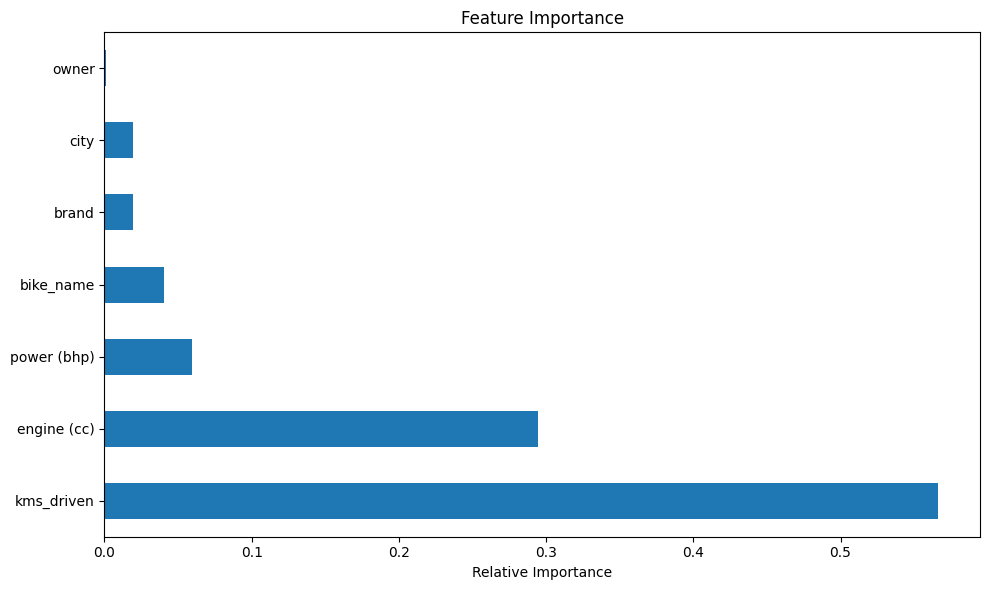

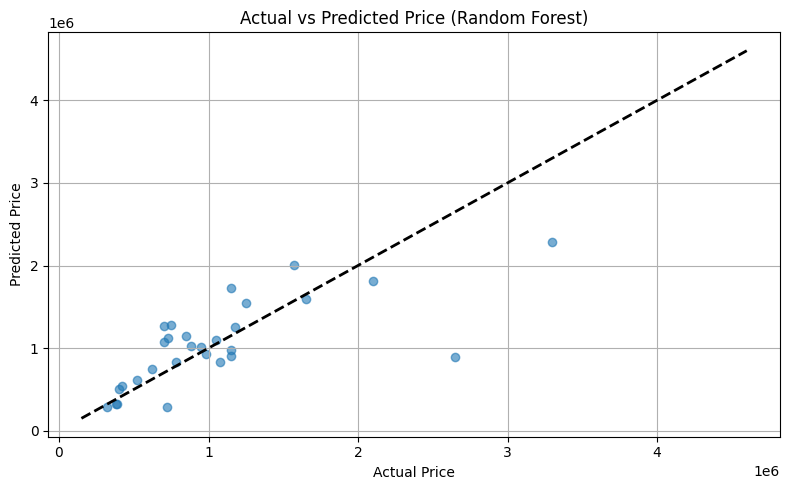

In [1]:
# 📦 Install necessary packages
!pip install pandas scikit-learn matplotlib seaborn --quiet

# 🌐 Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

# 📂 Step 2: Load Dataset from GitHub
url = "https://raw.githubusercontent.com/Arnav6595/ML_Project_6595/main/superbike_dataset.csv"
df = pd.read_csv(url)

# 🧼 Step 3: Data Preprocessing
df = df[['bike_name', 'price (INR)', 'city', 'kms_driven', 'owner', 'age', 'power (bhp)', 'brand', 'engine (cc)']]
df.dropna(inplace=True)
df['kms_driven'] = df['kms_driven'].astype(str).str.replace(',', '').str.extract('(\d+)').astype(float)

# 📊 Step 4: Encode all object (string) columns using Label Encoding
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])  # Fit and transform the training data
    label_encoders[col] = le  # Store the encoder for future use

# 🤖 Step 5: Define Input and Target
X = df.drop(['price (INR)', 'age'], axis=1)
y = df['price (INR)']

# 🧾 Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🤖 Step 7: Train Random Forest Model with Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

# 🧾 Step 8: Evaluate Model
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\n=== Model Evaluation ===")
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R² Score: {r2:.4f}")

# 📉 Step 9: Visualize Results
# Feature Importance
plt.figure(figsize=(10, 6))
feature_importances = pd.Series(best_rf.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importance')
plt.xlabel('Relative Importance')
plt.tight_layout()
plt.show()

# Scatter Plot (Actual vs Predicted Price)
plt.figure(figsize=(8, 5))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs Predicted Price (Random Forest)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [2]:
import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

# Assuming you have already trained a model and created label encoders

# Example: train a simple model (make sure you train your model first)
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Save the model and label encoders
joblib.dump(model, 'random_forest_model.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')

['label_encoders.pkl']

In [3]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 16.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 102.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.3 MB/s eta 0:00:00


In [4]:
import joblib
import pandas as pd
import gradio as gr

# Load the trained model and label encoders
model = joblib.load('random_forest_model.pkl')
label_encoders = joblib.load('label_encoders.pkl')

# Prediction function
def predict_price(bike_name, city, kms_driven, owner, power, brand, engine_cc):
    try:
        # Prepare the input data by transforming the categorical columns with label encoders
        input_dict = {
            'bike_name': label_encoders['bike_name'].transform([bike_name])[0],
            'city': label_encoders['city'].transform([city])[0],
            'kms_driven': float(kms_driven),
            'owner': label_encoders['owner'].transform([owner])[0],
            'power (bhp)': float(power),
            'brand': label_encoders['brand'].transform([brand])[0],
            'engine (cc)': float(engine_cc)  # Add engine (cc) as input
        }

        # Create a DataFrame for the input data
        input_df = pd.DataFrame([input_dict])

        # Debugging: Check the input DataFrame before prediction
        print(f"Input Data for Prediction:\n{input_df}")

        # Predict the price
        prediction = model.predict(input_df)[0]

        # Return the formatted prediction
        return f"💰 Estimated Resale Price: ₹{int(prediction):,}"

    except Exception as e:
        # Return any error message that occurs
        return f"❌ Error: {e}"

# Gradio UI components
inputs = [
    gr.Dropdown(choices=label_encoders['bike_name'].classes_.tolist(), label="Bike Name"),
    gr.Dropdown(choices=label_encoders['city'].classes_.tolist(), label="City"),
    gr.Number(label="Kilometers Driven"),
    gr.Dropdown(choices=label_encoders['owner'].classes_.tolist(), label="Owner Type"),
    gr.Number(label="Power (BHP)"),
    gr.Dropdown(choices=label_encoders['brand'].classes_.tolist(), label="Brand"),
    gr.Number(label="Engine (CC)")  # Add Engine (CC) as input field
]

output = gr.Textbox(label="Predicted Price")

# Gradio interface
interface = gr.Interface(fn=predict_price, inputs=inputs, outputs=output, title="🏍️ Superbike Resale Price Predictor", description="Enter the bike details below to get an estimated resale price (₹)")
interface.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8a1103998756b2dead.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
